# MIDDLEWARE: HUMAN IN THE LOOP 

- Add an interrupt in after_model 
- Triggered when execute_sqls is called
  
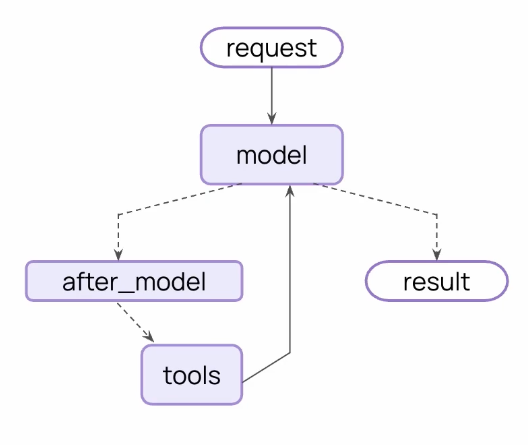

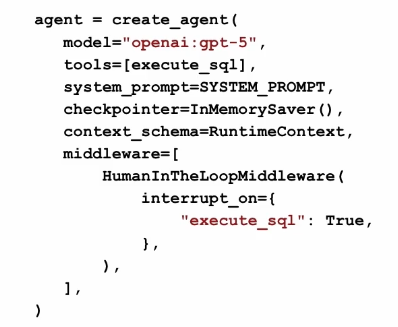

In [1]:
import utility as ut

OPENAI_API_KEY = ut.OPENAI_API_KEY
LANGSMITH_API_KEY = ut.LANGSMITH_API_KEY
MODEL_NAME = ut.MODEL_NAME

In [2]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [4]:
from dataclasses import dataclass

@dataclass
class RuntimeContext:
    db: SQLDatabase

In [5]:
from langchain_core.tools import tool 
from langgraph.runtime import get_runtime

@tool
def execute_sql(query:str) -> str:
    """Execute a SQL Lite command and return results"""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

In [6]:
SYSTEM_PROMPT = """ You are a careful SQLite Analyst

Rules:
 - Think Step-by-Step.
 - When you need data, call the tool `execute_sql` with one SELECT query.
 - Read-Only only; No INSERT/UPDATE/DELETE/ALTER/DROP/TRUNCATE/CREATE/REPLACE.
 - Limit to 5 rows of output unless the user explicitely asks otherwise.
 - If you are getting wrong answer you can always list the tables in the db and check within those tables 
 - if the tool returns 'Error:', revise the SQL and try again
 - Prefer explicit column lists; avoid SELECT *
"""

In [9]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver

agent = create_agent(
    model=MODEL_NAME,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "execute_sql": {
                    "allowed_decisions": ["approve", "reject"]
                }
            },
        ),
    ],
)

In [11]:
from langgraph.types import Command

question = "what are the names of all employees?"

config = {"configurable":{"thread_id":"1"}}

result =  agent.invoke(
    {
        "messages": [{"role": "user", "content": question}]
    },
    config=config,
    context=RuntimeContext
)

if "__interrupt__" in result:
    description = result['__interrupt__'][-1].value['action_requests'][-1]['description']
    print(f"\033[1;3;31m{80 * '-'}\033[0m")
    print(f"\033[1;3;31m Interrupt: {description}\033[0m")

    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {
                        "type": "reject", 
                        "message": "DB is offline."
                    }
                ]
            }
        ), 
        config=config,
        context=RuntimeContext(db=db)
    )
    print(f"\033[1;3;31m{80 * '-'}\033[0m")

print (result["messages"][-1].content)

/Users/mia/myenv/lib/python3.11/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


--------------------------------------------------------------------------------
 Interrupt: Tool execution requires approval

Tool: execute_sql
Args: {'query': 'SELECT name FROM employees LIMIT 5;'}
--------------------------------------------------------------------------------



In [12]:
config = {"configurable":{"thread_id":"2"}}

result =  agent.invoke(
    {
        "messages": [{"role": "user", "content": question}]
    },
    config=config,
    context=RuntimeContext
)

while "__interrupt__" in result:
    description = result['__interrupt__'][-1].value['action_requests'][-1]['description']
    print(f"\033[1;3;31m{80 * '-'}\033[0m")
    print(f"\033[1;3;31m Interrupt: {description}\033[0m")

    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {
                        "type": "approve", 
                    }
                ]
            }
        ), 
        config=config,
        context=RuntimeContext(db=db)
    )
    print(f"\033[1;3;31m{80 * '-'}\033[0m")

print (result["messages"][-1].content)

--------------------------------------------------------------------------------
 Interrupt: Tool execution requires approval

Tool: execute_sql
Args: {'query': 'SELECT name FROM employees LIMIT 5;'}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 Interrupt: Tool execution requires approval

Tool: execute_sql
Args: {'query': "SELECT name FROM sqlite_master WHERE type='table';"}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 Interrupt: Tool execution requires approval

Tool: execute_sql
Args: {'query': 'SELECT name FROM Employee LIMIT 5;'}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 Interrupt: Tool execution requires approval

Tool: execute_sq